# GeoPandas

In [1]:
import pandas as pd
import geopandas
import folium
from folium.plugins import MarkerCluster
import matplotlib.pyplot as plt
from shapely import wkt

In [2]:
df = pd.read_csv("Hospitals.csv", usecols=["ID", "NAME", "CITY", "STATE", "LATITUDE", "LONGITUDE"])

In [3]:
gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.LONGITUDE, df.LATITUDE))

In [4]:
gdf.head()

ID                                               NAME      CITY  \
0   76777520  HOUSTON METHODIST SAN JACINTO HOSPITAL ALEXAND...   BAYTOWN   
1  129043230                              WOODS AT PARKSIDE,THE  COLUMBUS   
2  130045404                         DAYTON CHILDREN'S HOSPITAL    DAYTON   
3  128844512                  VIBRA HOSPITAL OF MAHONING VALLEY  BOARDMAN   
4  129845417             HAVEN BEHAVIORAL SENIOR CARE OF DAYTON    DAYTON   

  STATE   LATITUDE  LONGITUDE                    geometry  
0    TX  29.747620 -94.945477  POINT (-94.94548 29.74762)  
1    OH  40.027143 -82.881843  POINT (-82.88184 40.02714)  
2    OH  39.774242 -84.168027  POINT (-84.16803 39.77424)  
3    OH  41.005169 -80.632972  POINT (-80.63297 41.00517)  
4    OH  39.747740 -84.199398  POINT (-84.19940 39.74774)

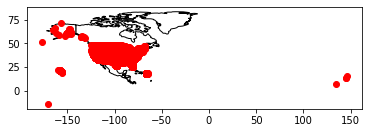

In [5]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# We restrict to North America.
ax = world[world.continent == 'North America'].plot(
    color='white', edgecolor='black')

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, color='red')

plt.show()

In [7]:
df_counties = pd.read_csv("counties_wkt.csv", usecols=['NAME', 'STATE_NAME', 'POP2000', 'shape_WKT'])

In [8]:
df_counties['geometry'] = geopandas.GeoSeries.from_wkt(df_counties['shape_WKT'])

In [10]:
gdf_c = gdf.sample(60)

In [11]:
m = folium.Map(location=[52, -105], 
               zoom_start=4,
               min_zoom=4, 
               max_zoom=7,
               width=1200, 
               height=700,
               tiles='CartoDB positron')

for i in range(len(gdf_c)):
  lat = gdf_c.iloc[i]["geometry"].y
  lon = gdf_c.iloc[i]["geometry"].x
  folium.Marker([lat, lon], 
                popup=gdf_c.iloc[i]["NAME"],
                icon=folium.Icon(icon_color='white', 
                                icon='info', 
                                angle=0, 
                                prefix='fa'),
                ).add_to(m)

m

In [12]:
m = folium.Map(location=[52, -105], 
               zoom_start=4,
               min_zoom=4, 
               max_zoom=7,
               width=1200, 
               height=700,
               tiles='CartoDB positron')

marker_cluster = MarkerCluster().add_to(m)

for i in range(len(gdf_c)):
  lat = gdf_c.iloc[i]["geometry"].y
  lon = gdf_c.iloc[i]["geometry"].x
  folium.Marker([lat, lon], popup=gdf_c.iloc[i]["NAME"]).add_to(marker_cluster)

m

In [13]:
geo_df = geopandas.GeoDataFrame(df_counties.sample(2000))
geo_counties = geo_df.dissolve(by="NAME")
geo_counties = geo_counties.set_crs(4326, allow_override=True)
geo_counties["s_name"] = geo_counties.index

In [14]:
m = folium.Map(location=[52, -105], 
               zoom_start=4,
               min_zoom=4, 
               max_zoom=7,
               width=1200, 
               height=700,
               tiles='CartoDB positron')

folium.Choropleth(geo_counties,                                # geo data
                  data=geo_counties,                           # data
                  key_on='feature.properties.s_name',    # feature.properties.key
                  columns=['s_name', 'POP2000'],         # [key, value]
                  fill_color='RdBu',                      # cmap
                  line_weight=0.1,                       # line wight (of the border)
                  line_opacity=0.5,                      # line opacity (of the border)
                  legend_name='Population').add_to(m)    # name on the legend color bar

# add layer controls
folium.LayerControl().add_to(m)
m

In [16]:
df_counties = pd.read_csv("counties_wkt.csv", usecols=['recordId', 'NAME', 'STATE_NAME', 'POP2000', 'shape_WKT'])

geo_counties = geopandas.GeoDataFrame(
    df_counties, geometry=geopandas.GeoSeries.from_wkt(df_counties['shape_WKT']))

geo_counties = geo_counties.dissolve(by="recordId")
geo_counties = geo_counties.set_crs(4326, allow_override=True)

In [17]:
def search_to_close(df, position, out=True, n_val=1):
  df_c = df
  dist = []
  for i in range(len(df)):
    distance = position.distance(df_c.iloc[i]["geometry"])
    dist.append(distance)
  df_c["distance"] = dist
  df_c = df_c.sort_values("distance")
  if out:
    df_c = df_c.iloc[1:n_val+1].reset_index(drop=True)
  else:
    df_c = df_c[df_c["distance"] == 0]
  return df_c
  

In [18]:
gdf

ID                                               NAME  \
0      76777520  HOUSTON METHODIST SAN JACINTO HOSPITAL ALEXAND...   
1     129043230                              WOODS AT PARKSIDE,THE   
2     130045404                         DAYTON CHILDREN'S HOSPITAL   
3     128844512                  VIBRA HOSPITAL OF MAHONING VALLEY   
4     129845417             HAVEN BEHAVIORAL SENIOR CARE OF DAYTON   
...         ...                                                ...   
7565  128243953                                 LIFE LINE HOSPITAL   
7566  127744621                              TEN LAKES CENTER, LLC   
7567  128345040                             LINDNER CENTER OF HOPE   
7568   13879022                           CUERO COMMUNITY HOSPITAL   
7569   76677004        HARRIS HEALTH SYSTEM QUENTIN MEASE HOSPITAL   

              CITY STATE   LATITUDE  LONGITUDE                    geometry  
0          BAYTOWN    TX  29.747620 -94.945477  POINT (-94.94548 29.74762)  
1         COLUMBUS    OH  40.027143 -82.881843  POINT (-82.88184 40.02714)  
2           DAYTON    OH  39.774242 -84.168027  POINT (-84.16803 39.77424)  
3         BOARDMAN    OH  41.005169 -80.632972  POINT (-80.63297 41.00517)  
4           DAYTON    OH  39.747740 -84.199398  POINT (-84.19940 39.74774)  
...            ...   ...        ...        ...                         ...  
7565  WINTERSVILLE    OH  40.372434 -80.701221  POINT (-80.70122 40.37243)  
7566      DENNISON    OH  40.401257 -81.336345  POINT (-81.33635 40.40126)  
7567         MASON    OH  39.331523 -84.294586  POINT (-84.29459 39.33152)  
7568         CUERO    TX  29.112615 -97.283341  POINT (-97.28334 29.11262)  
7569       HOUSTON    TX  29.711039 -95.359806  POINT (-95.35981 29.71104)  

[7570 rows x 7 columns]

In [19]:
state_codes = pd.read_csv("state_codes.csv")

In [20]:
def set_st_code(df, state):
  return df[df.state == state].iloc[0][1]

In [21]:
geo_counties["STATE_CODE"] = geo_counties.STATE_NAME.apply(lambda x: set_st_code(state_codes, x))

In [22]:
gdf

ID                                               NAME  \
0      76777520  HOUSTON METHODIST SAN JACINTO HOSPITAL ALEXAND...   
1     129043230                              WOODS AT PARKSIDE,THE   
2     130045404                         DAYTON CHILDREN'S HOSPITAL   
3     128844512                  VIBRA HOSPITAL OF MAHONING VALLEY   
4     129845417             HAVEN BEHAVIORAL SENIOR CARE OF DAYTON   
...         ...                                                ...   
7565  128243953                                 LIFE LINE HOSPITAL   
7566  127744621                              TEN LAKES CENTER, LLC   
7567  128345040                             LINDNER CENTER OF HOPE   
7568   13879022                           CUERO COMMUNITY HOSPITAL   
7569   76677004        HARRIS HEALTH SYSTEM QUENTIN MEASE HOSPITAL   

              CITY STATE   LATITUDE  LONGITUDE                    geometry  
0          BAYTOWN    TX  29.747620 -94.945477  POINT (-94.94548 29.74762)  
1         COLUMBUS    OH  40.027143 -82.881843  POINT (-82.88184 40.02714)  
2           DAYTON    OH  39.774242 -84.168027  POINT (-84.16803 39.77424)  
3         BOARDMAN    OH  41.005169 -80.632972  POINT (-80.63297 41.00517)  
4           DAYTON    OH  39.747740 -84.199398  POINT (-84.19940 39.74774)  
...            ...   ...        ...        ...                         ...  
7565  WINTERSVILLE    OH  40.372434 -80.701221  POINT (-80.70122 40.37243)  
7566      DENNISON    OH  40.401257 -81.336345  POINT (-81.33635 40.40126)  
7567         MASON    OH  39.331523 -84.294586  POINT (-84.29459 39.33152)  
7568         CUERO    TX  29.112615 -97.283341  POINT (-97.28334 29.11262)  
7569       HOUSTON    TX  29.711039 -95.359806  POINT (-95.35981 29.71104)  

[7570 rows x 7 columns]

In [23]:
OUT = False
n_val = 5
state = "TX"

dm = geo_counties[geo_counties["STATE_CODE"] == state].reset_index(drop=True)
#dm = geo_counties.sample(10).reset_index(drop=True)
gdf_cc = gdf[gdf["STATE"] == state].reset_index(drop=True)

print(f"Procesando {len(dm)} registros.")

m = folium.Map(location=[52, -105], 
               zoom_start=4,
               min_zoom=4, 
               max_zoom=12,
               width=1200, 
               height=700,
               tiles='CartoDB positron')

marker_cluster = MarkerCluster().add_to(m)

for s in range(len(dm)):
  data_s = search_to_close(gdf_cc, dm.iloc[s]["geometry"], out=OUT, n_val=n_val)

  for i in range(len(data_s)):
    lat = data_s.iloc[i]["geometry"].y
    lon = data_s.iloc[i]["geometry"].x
    folium.Marker([lat, lon], 
                  #popup=data_s.iloc[i]["NAME"],
                  tooltip=f'<b>{data_s.iloc[i]["NAME"]}</b><br><br>\
                  Distance: {round(data_s.iloc[i]["distance"],2)}', 
                  icon=folium.Icon(icon_color='white', 
                                  icon='info', 
                                  angle=0, 
                                  prefix='fa'),
                  ).add_to(marker_cluster)
  
  sim_geo  = geopandas.GeoSeries(dm.iloc[s]["geometry"]).simplify(tolerance=0.001)
  geo_j = sim_geo.to_json()
  geo_j = folium.GeoJson(data=geo_j,
                          style_function=lambda x: {'fillColor': 'orange'})
  folium.Popup(dm['STATE_NAME']).add_to(geo_j)
  geo_j.add_to(m)


m

Procesando 254 registros.
